# Figure 5 Data

This folder contains data digitized from Klix, et.al. PRX (2016) paper and code that applies RG equations to their data. They include:
- "bulk.csv": bulk modulus data
- "shear_inset.csv": shear modulus data
- "bulk_inset.csv": another set of bulk modulus data

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
mpl.rcParams['text.usetex'] = True

In [20]:
def lin(x,a,b):
    return a*x+b

def red():
    return '#d65858'
def blue():
    return '#1E90FF'
def black():
    return '#000000'
def orange():
    return '#FF8C00'
def brown():
    return '#A52A2A'
def darkorchid():
    return '#9932CC'
def darkgreen():
    return '#006400'

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

We now look at P. Keim's data from Phys. Rev. X 5, 041033, which has elastic moduli measurements with them. 

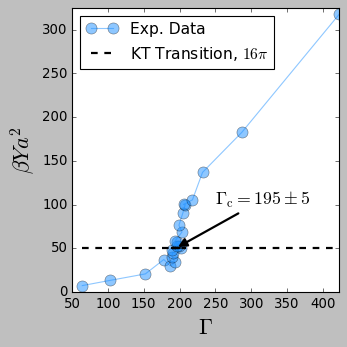

In [21]:
import numpy as np
import pandas as pd

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

bulk = pd.read_csv("bulk.csv",header=None)
shear = pd.read_csv("shear_inset.csv",header=None)
bulk_inset = pd.read_csv("bulk_inset.csv", header=None)
bulk = pd.concat((bulk,bulk_inset))
bulk = bulk.sort_values(by=0)

#We use the shear modulus data, look through one by one and determine
#which datapoint corresponds to which
young_exp = []
shear_exp = []
nu_exp = []
bulk_exp = []
x_exp = []
for index, row in shear.iterrows():
    #Keep matching
    findmin = []
    bulkval = []
    for index1, row1 in bulk.iterrows():
        findmin.append(np.abs(row1[0]-row[0]))
        bulkval.append(row1[1])
    idx = np.argmin(findmin)
    bulkval = bulkval[int(idx)]
    bulk_exp.append(bulkval)
    shear_exp.append(row[1])#1/row[1])**(-1))
    young_inv = 0.25*(1/bulkval+1/row[1])
    young_exp.append(1/young_inv)
    
    nu_exp.append(1/(2*row[1]*young_inv)-1.0)
    #print(nu_exp)
    x_exp.append(row[0])

import matplotlib.pyplot as plt

x_exp = np.array(x_exp)
young_exp = np.array(young_exp)


plt.figure(figsize=(4.5,4.5))
plt.plot(x_exp,young_exp,'-o',color=blue(),markersize=10,alpha=0.5,label=r"Exp. Data")


#(4) Location of transition according to the Paper
#plt.axvline(x=195,color='k',label="$\Gamma_\mathrm{KT} = 195 \pm 5$")
arrowprops=dict(arrowstyle='-|>', color='black', linewidth=2)
plt.annotate("$\Gamma_\mathrm{c} = 195 \pm 5$",fontsize=16,xy=(195,16*np.pi),xytext=(250,100),arrowprops=arrowprops)
plt.plot(x_exp,16*np.pi*np.ones_like(x_exp),'k--',linewidth=2,label=r"KT Transition, $16\pi$")

plt.ylabel(r"$\beta Y a^2$",fontsize=20)
plt.xlabel(r"$\Gamma$",fontsize=20)
plt.ylim([0,325])
plt.xlim([50,max(x_exp)])
plt.tight_layout()
#lgd = plt.legend(loc="upper right",fontsize=14,bbox_to_anchor=(2.0, 1.0))
lgd = plt.legend(loc="upper left",fontsize=14)#,bbox_to_anchor=(2.0, 1.0))
plt.show()#close()

Let's try and replicate the RG calculation for P. Keim's data. First look at the initial conditions for the RG flow, i.e., the elastic moduli at high $\Gamma$ values

0.9570904920019618 0.07082383811575617 -87.93155934023173 22.93313124790091
0.3018505013808677 0.03000620987386365 -29.082439502163957 9.716168742800432
1.1455426994777713 0.058027850341382796 -81.03098094567665 18.789723145430276


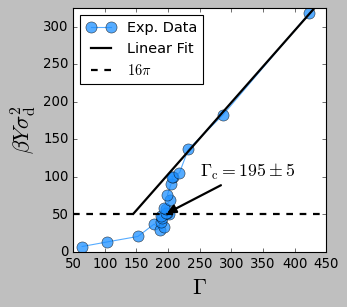

In [22]:
# ===========
# Initial Conditions

#We obtain using the last three datapoints 
#Need initial conditions for fugacity and Young's modulus

from scipy.optimize import curve_fit

def YIS(x,a,b):
    return a*x+b

def GIS(x,a,b):
    return a*x+b

lastindex = 3
popt, pcov = curve_fit(YIS, x_exp[-lastindex:],young_exp[-lastindex:])
print(popt[0],2*pcov[0,0]**0.5,popt[1],2*pcov[1,1]**0.5)
popt1, pcov1 = curve_fit(GIS, x_exp[-lastindex:],shear_exp[-lastindex:])
print(popt1[0],2*pcov1[0,0]**0.5,popt1[1],2*pcov1[1,1]**0.5)
popt2, pcov2 = curve_fit(GIS, x_exp[-lastindex:],bulk_exp[-lastindex:])
print(popt2[0],2*pcov2[0,0]**0.5,popt2[1],2*pcov2[1,1]**0.5)

#Initial conditions
plt.figure(figsize=(4.5,4.0))
plt.plot(x_exp,young_exp,'-o',color=blue(),markersize=10,alpha=0.75,label=r"Exp. Data")
x = np.linspace(145,450)
plt.plot(x,YIS(x,*popt),'-',linewidth=2.0,color=black(),fillstyle='none',label=r"Linear Fit")

#(4) Location of transition according to the Paper
#plt.axvline(x=195,color='k',label="$\Gamma_\mathrm{KT} = 195 \pm 5$")
arrowprops=dict(arrowstyle='-|>', color='black', linewidth=2)
plt.annotate("$\Gamma_\mathrm{c} = 195 \pm 5$",fontsize=16,xy=(195,16*np.pi),xytext=(250,2*16*np.pi),arrowprops=arrowprops)
x = np.linspace(50,450)
plt.plot(x,16*np.pi*np.ones_like(x),'k--',linewidth=2,label=r"$16\pi$")

plt.ylabel(r"$\beta Y \sigma_\mathrm{d}^2$",fontsize=20)
plt.xlabel(r"$\Gamma$",fontsize=20)
plt.ylim([0,325])
plt.tight_layout()
plt.legend(loc="upper left",fontsize=13)
plt.show()

In [23]:
from scipy.special import iv 
from scipy.integrate import solve_ivp

#Define the RG flow equations
def flow(t,x):
    Kinvr = 0.25*(np.pi**2*x[1]**2)*np.exp(1/(8*np.pi*x[0]))*(2*iv(0,1/(8*np.pi*x[0]))-iv(1,1/(8*np.pi*x[0])))
    yr = (2-1/(8*np.pi*x[0]))*x[1]+2*(np.pi*x[1]**2)*np.exp(1/(16*np.pi*x[0]))*iv(0,1/(8*np.pi*x[0]))
    return np.array([Kinvr,yr])

#Use fugacity formula we derived from paper
def fug(betaYpsq,nu):
    C = 0.25*(3+nu)
    Ec = betaYpsq/(8*np.pi)*(C+1)
    return np.exp(-Ec)

#The dipole magnitude
def dc(xin,poptin,popt1in,udd):
    #Compute dc by back-calculating from the Jsigma formula
    #Gis = GIS(xin,*popt1in)
    nu = YIS(xin,*poptin)/(2*GIS(xin,*popt1in))-1.0
    #Js = 6.0*np.pi*Gis*(udd**2)*(1.0+udd)**2/(1.0+2.0*udd)**4
    ec = 2*2**0.5*(1+udd)*udd/(1+2*udd)
    Rexc = 0.5*3**0.5/(1+2*udd)
    dcmag = 2.0*np.pi*Rexc*ec/(1.0+nu)
    return dcmag

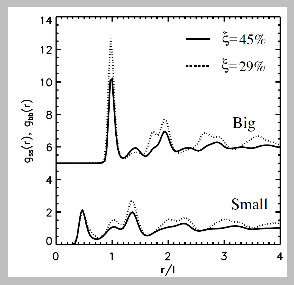

Available udd (big particles, small particles) (0.10389610389610399, 0.13636363636363646)
Running RG flow . . .
Finished


In [24]:
#We'll estimate based on the real temperature data
newx = np.linspace(190,500,500)[::-1]

### Trying estimate dipole magnitude 
### from local structure properties

# Data from Eur. Phys. J. E 26, 161–168 (2008)
# There is radial distribution function data for the pair g_AA and g_BB
# They are measured at \Gamma = 556. This is very supercooled!
# Interestingly across 45% and 25% percent mixtures, the peak locations
# at short-range of first solcation shell don't change much, 
# so it should be applicable to our setting which is at ~50% mixture. 
# The data was reported in terms of effective diameter of large particle
# So we need to express data back in terms of average diameter of these particle
# mixtures

sigmaaa = 0.47
sigmabb = 1.0
m = 0.66/6.22
nonadd = 2*m**(1/3)/(1+m**(2/3))-1.0                     
sigmaab = 0.5*(nonadd+1)*(sigmaaa+sigmabb)
xi = 0.45
sigma = xi*sigmaaa+(1-xi)*sigmabb 
udbig = 0.5*np.abs(0.9870129870129868-1.1948051948051948)
udsmall = 0.5*np.abs(0.4610389610389608-0.7337662337662337)
xi = 0.50

im = plt.imread("gaa_gbb.png")
plt.figure(figsize=(4.5,4.5))
im = plt.imshow(im)
plt.axis('off')
plt.show()
print("Available udd (big particles, small particles)", (udbig,udsmall))

print("Running RG flow . . .")
newx = np.linspace(170,500,1000)[::-1]
udd = udsmall
dcmag = dc(newx,popt,popt1,udd)
factor = dcmag*dcmag
betaYpsqSmall = YIS(newx,*popt)*factor
betaGpsqSmall = GIS(newx,*popt1)*factor  


udd = udbig
dcmag = dc(newx,popt,popt1,udd)
factor = dcmag*dcmag
betaYpsqBig = YIS(newx,*popt)*factor
betaGpsqBig = GIS(newx,*popt1)*factor  
nu = betaYpsqBig/(2*betaGpsqBig)-1.0
KRG = []

#According to their experimental setup 
#The order of magnitude of particles is O(10^5)
#NParticles = 10**5
Length = 20.5
max_t = np.log(Length)
dt = 1e-4
for j in range(len(newx)):
    t = np.linspace(0,max_t,int(max_t/dt))
    xi = 0.5
    betaYpsq = xi*betaYpsqBig+(1-xi)*betaYpsqSmall
    y0 = np.array([1/betaYpsq[j],fug(betaYpsq[j],nu[j])])#,betaGpsq[j]])
    sol = solve_ivp(fun=flow,t_span=(0,max_t),y0=y0,t_eval=t,method='BDF')#Radau')
    KRG.append(1/sol.y[0,-1])
KRG = np.array(KRG)
print("Finished")
np.savetxt("YRG_keim.txt",np.vstack((newx,KRG)).T)

## Plot Resulting Data

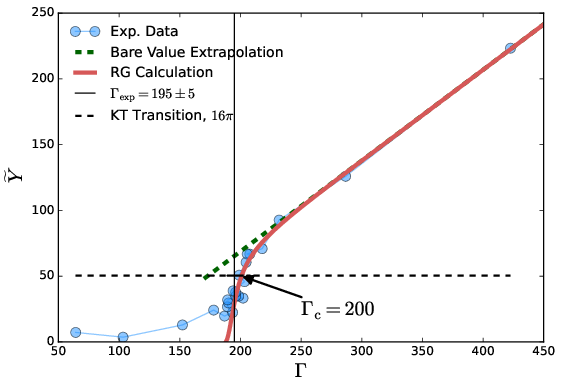

In [25]:
plt.figure(figsize=(8,8*0.7))

#(1) The experimental data in terms of dipole magnitude
#udd = 0.1238#0.1196022107558044
#dcmag = dc(x_exp,popt,popt1,udd)
udd = udsmall
dcmag = dc(x_exp,popt,popt1,udd)
factor = dcmag*dcmag
factorsmall = factor

udd = udbig
dcmag = dc(x_exp,popt,popt1,udd)
factor = dcmag*dcmag
factorbig = factor

dcmag = np.sqrt(0.5*factorsmall+0.5*factorbig)
plt.plot(x_exp,young_exp*dcmag*dcmag,'-o',color=blue(),markersize=10,alpha=0.5,label=r"Exp. Data")

#(2) The low-T plateau extrapolation (which is a linear line
xis = np.linspace(170,500)
udd = udsmall
dcmag = dc(xis,popt,popt1,udd)
factor = dcmag*dcmag
factorsmall = factor

udd = udbig
dcmag = dc(xis,popt,popt1,udd)
factor = dcmag*dcmag
factorbig = factor

dcmag = np.sqrt(0.5*factorsmall+0.5*factorbig)
plt.plot(xis,YIS(xis,*popt)*dcmag*dcmag,'--',color=darkgreen(),linewidth=4.0,label=r"Bare Value Extrapolation")

#(3) RG Calculation
data = np.loadtxt("YRG_keim.txt")
xrg = data[:,0]#[K > 1]
Krg = data[:,1]#K[K > 1]

xrg = xrg[Krg> 0.1]
Krg = Krg[Krg > 0.1]

plt.plot(xrg,Krg,'-',color=red(),linewidth=4.0,label='RG Calculation')#, \n $\\tilde{{u}}^\dag = {}$'.format(round(udd,3)))

#(4) Location of transition according to the Paper
plt.axvline(x=195,color='k',label="$\Gamma_\mathrm{exp} = 195 \pm 5$")
arrowprops=dict(arrowstyle='-|>', color='black', linewidth=2)
plt.annotate("$\Gamma_\mathrm{c} = 200$",fontsize=20,xy=(200,16*np.pi),xytext=(250,20),arrowprops=arrowprops)
plt.plot(x_exp,16*np.pi*np.ones_like(x_exp),'k--',linewidth=2,label=r"KT Transition, $16\pi$")

#Labeling
plt.ylabel(r"$\widetilde{Y}$",fontsize=20)
plt.xlabel(r"$\Gamma$",fontsize=20)
plt.ylim([0,250])
plt.xlim([50,450])#max(x_exp)])
plt.tight_layout()
lgd = plt.legend(loc="upper left",fontsize=14,frameon=False)#top)$bbox_to_anchor=(2.0, 1.0))

plt.savefig('YRG_keim_save.pdf',dpi=300, bbox_inches='tight')
plt.close()

from wand.image import Image as WImage
img = WImage(filename='YRG_keim_save.pdf')
img